In [5]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import *
from scipy.stats import zscore
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import shap
import lime
from PyALE import ale
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

random_state = 1000

In [2]:
df = pd.read_csv('../data/rock_data.csv')

# handle missing values
if df.isnull().values.any():
    df.fillna(df.mean(), inplace=True)
    print('Missing values filled with mean.')

# detect and remove outliers

# drop highly correlated features
df.drop(['Area', 'Perimeter','Median Height', 'Max Height', 'STD Height'], axis=1, inplace=True)
df.columns

Index(['Sample ID', 'Rock ID', 'Class', 'Orientation', 'Axis Major Length',
       'Axis Minor Length', 'Mean Height', 'Mean Gradient', 'STD Gradient',
       'Gradient at Max', 'Weighted Hu Moment 1', 'Weighted Hu Moment 2',
       'Weighted Hu Moment 3', 'Weighted Hu Moment 4'],
      dtype='object')

In [3]:
X = df.iloc[:,3:].to_numpy(dtype=float)

def map_class_values(x):
    mapping = {12: 0, 58: 1, 34: 2}
    return mapping.get(x,None)

y = np.vectorize(map_class_values)(df['Class'].values)

In [4]:
# training:validation:testing = 60:20:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)

In [5]:
model_names = ['KNN', 'SVC', 'RF', 'XGB', 'MLP']
models = [KNeighborsClassifier(), SVC(), RandomForestClassifier(), XGBClassifier(), MLPClassifier(max_iter=500)]
grid_params = [{'n_neighbors': [5, 10, 15, 20], 'weights': ['uniform', 'distance']}, {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'sigmoid']}, {'n_estimators': [10, 100, 200], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_features': ['sqrt', 'log2', None]}, {'max_depth': [3,5,7], 'n_estimators': [10, 100, 200], 'reg_lambda': [1e-3, 1, 1e3]}, {'hidden_layer_sizes': [(100,), (100,50), (100,50,100)], 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'alpha': [1e-3, 1, 1e3]}]

In [73]:
def parse_report(y_val, model_best_pred, m, model_names, grid_search, dataset):
    """
    Parse classification report valeus to dataframe for posterior comparison of model performance.
    Returns:
    --------
    df: classification report values dataframe
    """
    report = classification_report(y_val, model_best_pred, output_dict=True)
    dict_values = {}
    dict_values['model']=model_names[m]
    dict_values['params']=np.array([grid_search.best_params_])
    dict_values['dataset']=dataset
    for elem, score in report.items():
        try:
            for score_name, score_num in score.items():
                if elem.isnumeric():
                    col_i = '_'.join(['class', elem.replace(" ", "_"), score_name])
                else:
                    col_i = '_'.join([elem.replace(" ", "_"), score_name])
                dict_values[col_i] = score_num
#                 col = np.append(col, col_i)
        except:
            col_i = elem
            dict_values[col_i] = score_num
#             col = np.append(col, col_i)
            continue
    df = pd.DataFrame(dict_values, index=[m])
    return df

KNN with {'n_neighbors': 15, 'weights': 'distance'} 
               precision    recall  f1-score   support

           0       0.77      0.84      0.80        88
           1       0.51      0.39      0.44        54
           2       0.74      0.79      0.76        76

    accuracy                           0.71       218
   macro avg       0.67      0.67      0.67       218
weighted avg       0.70      0.71      0.70       218




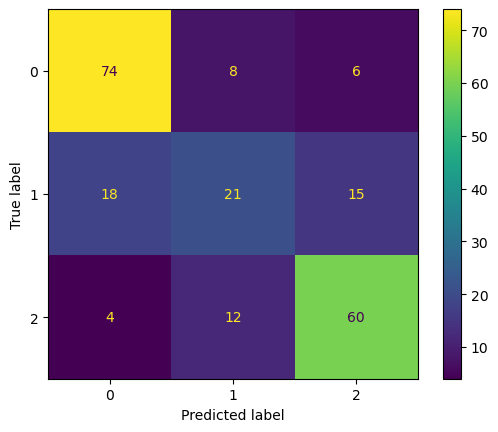

SVC with {'C': 10, 'kernel': 'rbf'} 
               precision    recall  f1-score   support

           0       0.77      0.82      0.80        88
           1       0.45      0.54      0.49        54
           2       0.80      0.63      0.71        76

    accuracy                           0.68       218
   macro avg       0.67      0.66      0.66       218
weighted avg       0.70      0.68      0.69       218




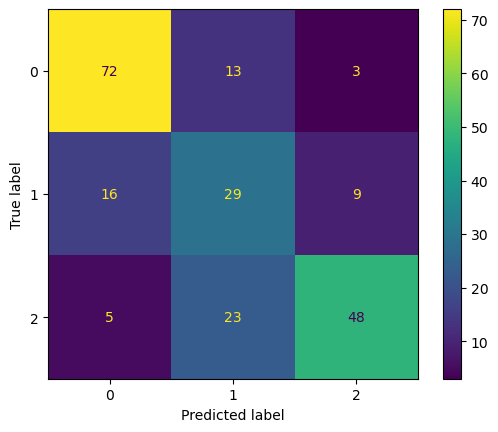

RF with {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 200} 
               precision    recall  f1-score   support

           0       0.78      0.82      0.80        88
           1       0.45      0.48      0.46        54
           2       0.75      0.67      0.71        76

    accuracy                           0.68       218
   macro avg       0.66      0.66      0.66       218
weighted avg       0.69      0.68      0.68       218




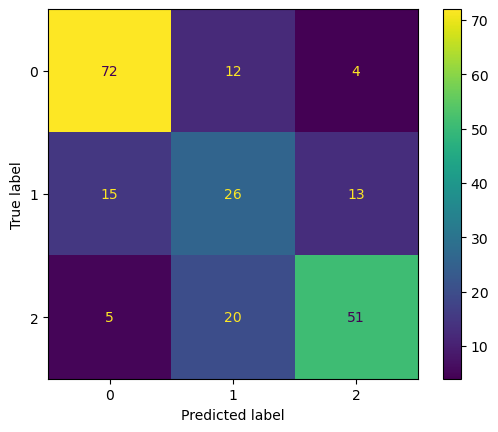

XGB with {'max_depth': 3, 'n_estimators': 100, 'reg_lambda': 1} 
               precision    recall  f1-score   support

           0       0.80      0.84      0.82        88
           1       0.44      0.52      0.48        54
           2       0.79      0.66      0.72        76

    accuracy                           0.70       218
   macro avg       0.68      0.67      0.67       218
weighted avg       0.71      0.70      0.70       218




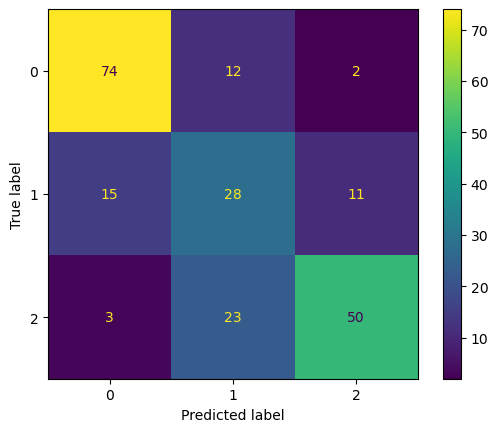

MLP with {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50)} 
               precision    recall  f1-score   support

           0       0.73      0.82      0.77        88
           1       0.47      0.35      0.40        54
           2       0.78      0.82      0.80        76

    accuracy                           0.70       218
   macro avg       0.66      0.66      0.66       218
weighted avg       0.68      0.70      0.69       218




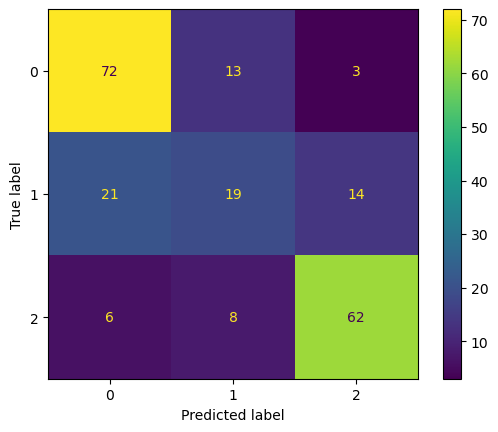

In [6]:
dataset = 'mean_height'
for m,model in enumerate(models):
    grid_search = GridSearchCV(model, grid_params[m], cv=5)
    grid_search.fit(X_train, y_train)
    model_best = grid_search.best_estimator_
    model_best_pred = model_best.predict(X_val)
    # Parse report to dataframe to compare results among models
    if m==0:
        results_df = parse_report(y_val, model_best_pred, m, model_names, grid_search, dataset)
    else:
        df_i = parse_report(y_val, model_best_pred, m, model_names, grid_search, dataset)
        results_df = pd.concat([results_df, df_i])
    # Print results
    print(f'{model_names[m]} with {grid_search.best_params_} \n {classification_report(y_val, model_best_pred)}\n')
    ConfusionMatrixDisplay(confusion_matrix(y_val, model_best_pred)).plot()
    show()

In [7]:
search_spaces = [{
    'n_neighbors': Integer(3,50),
    'weights': Categorical(['uniform', 'distance'])
    },
    
    {
    'C': Real(0.1, 10, 'log-uniform'),
    'kernel': Categorical(['linear', 'rbf', 'sigmoid']),
    },
    
    {
    'n_estimators': Integer(10,200),
    'criterion': Categorical(['gini', 'entropy', 'log_loss']),
    'max_features': Categorical(['sqrt', 'log2', None]),
    },
    
    {
    'max_depth': Integer(3,10),
    'n_estimators': Integer(10,200),
    'reg_lambda': Real(1e-3, 1e3, 'log-uniform'),
    }
    ]

KNN with OrderedDict([('n_neighbors', 14), ('weights', 'distance')]) 
               precision    recall  f1-score   support

           0       0.78      0.85      0.82        88
           1       0.51      0.41      0.45        54
           2       0.73      0.76      0.75        76

    accuracy                           0.71       218
   macro avg       0.68      0.67      0.67       218
weighted avg       0.70      0.71      0.70       218




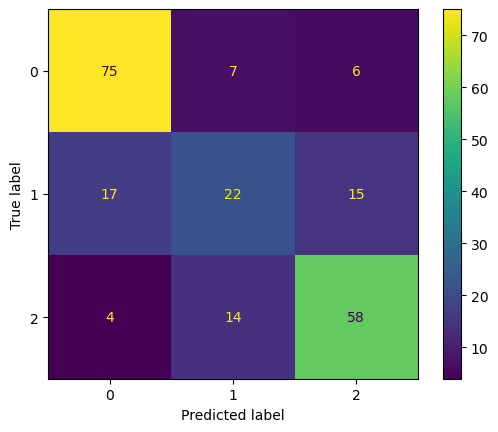

SVC with OrderedDict([('C', 10.0), ('kernel', 'rbf')]) 
               precision    recall  f1-score   support

           0       0.77      0.82      0.80        88
           1       0.45      0.54      0.49        54
           2       0.80      0.63      0.71        76

    accuracy                           0.68       218
   macro avg       0.67      0.66      0.66       218
weighted avg       0.70      0.68      0.69       218




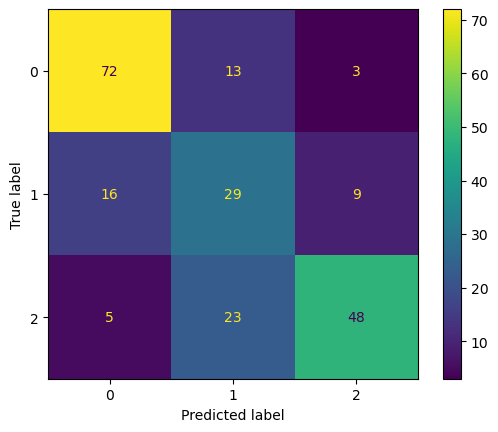

RF with OrderedDict([('criterion', 'log_loss'), ('max_features', 'sqrt'), ('n_estimators', 200)]) 
               precision    recall  f1-score   support

           0       0.77      0.82      0.80        88
           1       0.48      0.54      0.50        54
           2       0.80      0.67      0.73        76

    accuracy                           0.70       218
   macro avg       0.68      0.68      0.68       218
weighted avg       0.71      0.70      0.70       218




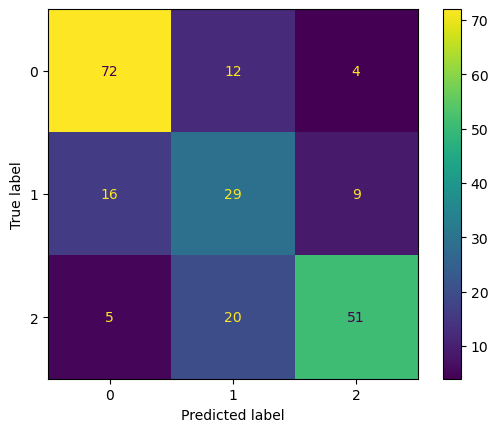

XGB with OrderedDict([('max_depth', 10), ('n_estimators', 33), ('reg_lambda', 0.001)]) 
               precision    recall  f1-score   support

           0       0.80      0.84      0.82        88
           1       0.48      0.52      0.50        54
           2       0.75      0.66      0.70        76

    accuracy                           0.70       218
   macro avg       0.67      0.67      0.67       218
weighted avg       0.70      0.70      0.70       218




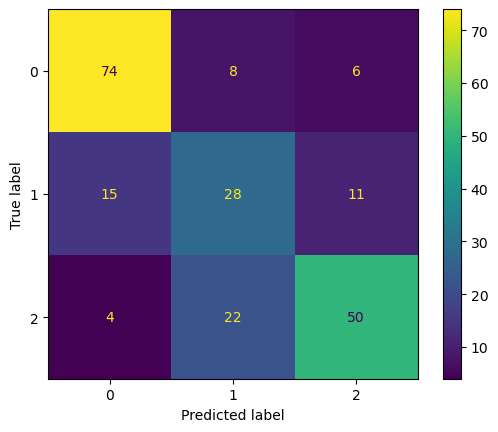

In [8]:
dataset = 'mean_height'
for m,model in enumerate(models[:-1]):
    bayes_search = BayesSearchCV(model, search_spaces[m], n_iter=50, cv=5, n_jobs=-1)
    bayes_search.fit(X_train, y_train)
    model_best = bayes_search.best_estimator_
    model_best_pred = model_best.predict(X_val)
    # Parse report to dataframe to compare results among models
    df_i = parse_report(y_val, model_best_pred, m, model_names, bayes_search, dataset)
    results_df = pd.concat([results_df, df_i])
    print(f'{model_names[m]} with {bayes_search.best_params_} \n {classification_report(y_val, model_best_pred)}\n')
    ConfusionMatrixDisplay(confusion_matrix(y_val, model_best_pred)).plot()
    show()

In [9]:
best_models = [KNeighborsClassifier(n_neighbors=15, weights= 'distance'), SVC(C=10, kernel='rbf'), RandomForestClassifier(criterion='log_loss', max_features= 'sqrt', n_estimators=200), XGBClassifier(max_depth=3, n_estimators=100, reg_lambda=1), MLPClassifier(max_iter=500, activation='logistic', alpha=0.001, hidden_layer_sizes=(100,50))]

KNeighborsClassifier(n_neighbors=15, weights='distance') 
               precision    recall  f1-score   support

           0       0.71      0.88      0.79        74
           1       0.66      0.51      0.58        68
           2       0.74      0.72      0.73        76

    accuracy                           0.71       218
   macro avg       0.71      0.71      0.70       218
weighted avg       0.71      0.71      0.70       218




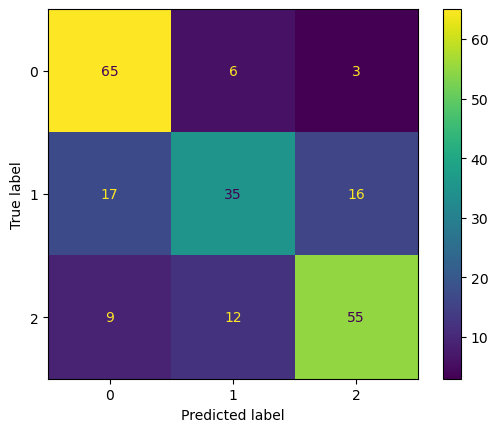

SVC(C=10) 
               precision    recall  f1-score   support

           0       0.70      0.86      0.78        74
           1       0.59      0.51      0.55        68
           2       0.75      0.67      0.71        76

    accuracy                           0.69       218
   macro avg       0.68      0.68      0.68       218
weighted avg       0.69      0.69      0.68       218




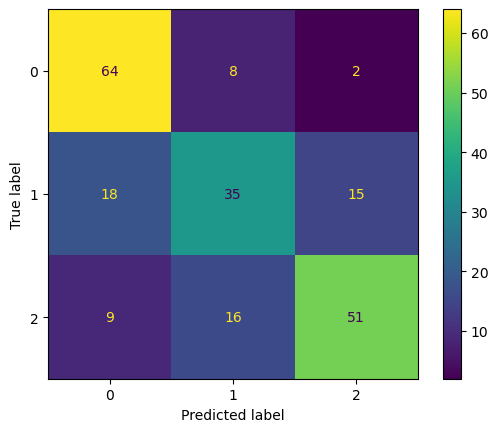

RandomForestClassifier(criterion='log_loss', n_estimators=200) 
               precision    recall  f1-score   support

           0       0.72      0.85      0.78        74
           1       0.62      0.59      0.60        68
           2       0.74      0.64      0.69        76

    accuracy                           0.70       218
   macro avg       0.69      0.69      0.69       218
weighted avg       0.70      0.70      0.69       218




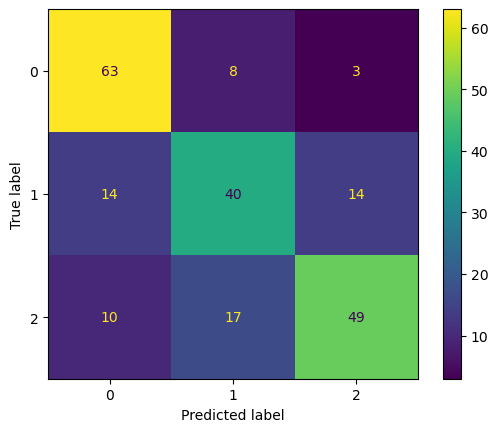

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...) 
               precision    recall  f1-score   support

           0       0.72      0.85      0.78        74
           1       0.58      0.54      0.56        68
           2       0.72      0.63      0.67        76

    accuracy          

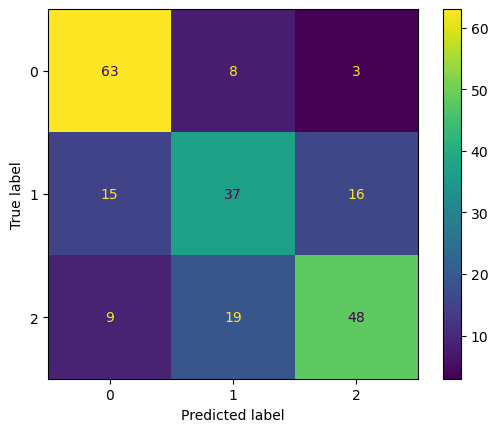

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(100, 50),
              max_iter=500) 
               precision    recall  f1-score   support

           0       0.70      0.88      0.78        74
           1       0.67      0.44      0.53        68
           2       0.71      0.75      0.73        76

    accuracy                           0.70       218
   macro avg       0.69      0.69      0.68       218
weighted avg       0.69      0.70      0.68       218




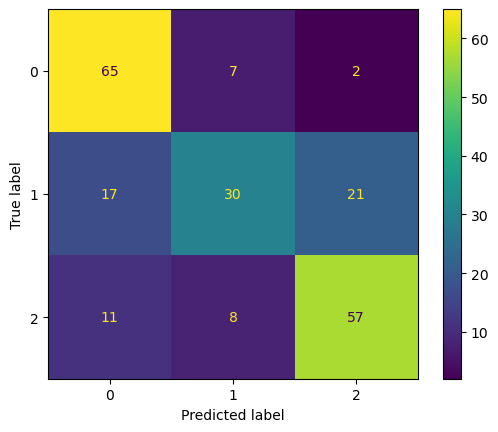

In [10]:
for m,model in enumerate(best_models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'{model} \n {classification_report(y_test, y_pred)}\n')
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    show()

In [11]:
best_model = KNeighborsClassifier(n_neighbors=15, weights='distance') 
best_model_cal_iso = CalibratedClassifierCV(best_model, method='isotonic')
best_model_cal_sig = CalibratedClassifierCV(best_model, method='sigmoid')
models = [best_model, best_model_cal_iso, best_model_cal_sig]        
labels = ['Uncalibrated', 'Isotonic', 'Sigmoid']
classes = ['12', '58', '34']
colors= ['r', 'g', 'b']

In [12]:
X_train, X_cal, y_train, y_cal = train_test_split(X, y, test_size=0.3, random_state=random_state+2)

for m, model in enumerate(models):
        model.fit(X_train, y_train)

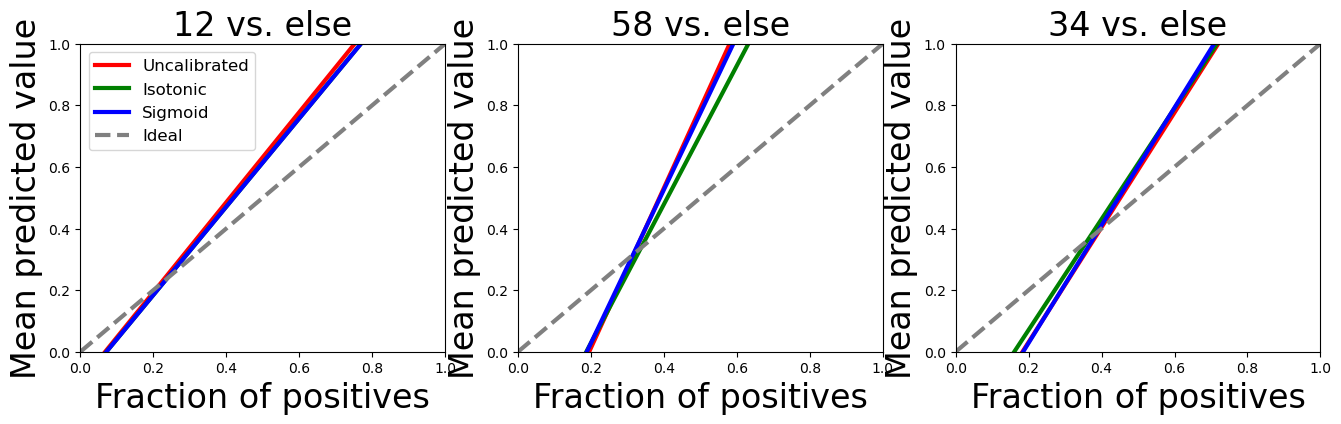

In [13]:
fig, axs = subplots(nrows=1, ncols=3, figsize=(16,4))

for i in range(3):
    for m, model in enumerate(models):
        y_pred = model.predict(X_cal)
        y_cal_b = np.vectorize(lambda x: 1 if x==i else 0)(y_cal)
        y_pred_b = np.vectorize(lambda x: 1 if x==i else 0)(y_pred)

        fop, mpv = calibration_curve(y_cal_b, (y_pred_b-y_pred_b.min())/y_pred_b.ptp(), n_bins=10)

        axs[i].plot(fop, mpv, color=colors[m], linestyle='-', linewidth=3, label=labels[m])


    axs[i].plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=3, label='Ideal')
    axs[i].set_xlim([0, 1])
    axs[i].set_ylim([0, 1])
    axs[i].set_xlabel('Fraction of positives', fontsize=24)
    axs[i].set_ylabel('Mean predicted value', fontsize=24)
    axs[i].set_title(f'{classes[i]} vs. else', fontsize=24)
    
    if i==0:
        axs[i].legend(loc='best' , fontsize=12)

show()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state+4)

for m, model in enumerate(models):
        model.fit(X_train, y_train)

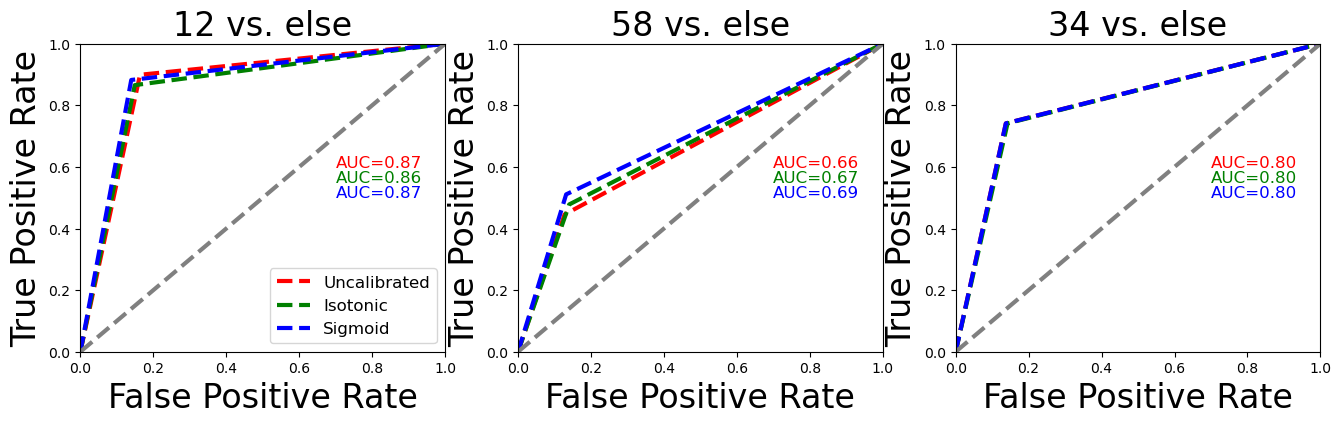

In [15]:
fig, axs = subplots(nrows=1, ncols=3, figsize=(16,4))

for i in range(3):
    for m, model in enumerate(models):
        y_pred = model.predict(X_test)
        y_test_b = np.vectorize(lambda x: 1 if x==i else 0)(y_test)
        y_pred_b = np.vectorize(lambda x: 1 if x==i else 0)(y_pred)

        fpr, tpr, thresholds = roc_curve(y_test_b, y_pred_b)

        axs[i].plot(fpr, tpr, color=colors[m], linestyle='--', linewidth=3, label=labels[m])
        axs[i].text(0.7, 0.6-0.05*m, f'AUC={auc(fpr, tpr):.2f}', color=colors[m], fontsize=12)

    axs[i].plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=3)
    axs[i].set_xlim([0, 1])
    axs[i].set_ylim([0, 1])
    axs[i].set_xlabel('False Positive Rate', fontsize=24)
    axs[i].set_ylabel('True Positive Rate', fontsize=24)
    axs[i].set_title(f'{classes[i]} vs. else', fontsize=24)
    

    if i==0:
        axs[i].legend(loc='best' , fontsize=12)
            
show()

In [16]:
X = df.iloc[:,3:]
y = df['Class']

In [19]:
best_model = RandomForestClassifier(criterion='log_loss', n_estimators=200)
best_model.fit(X, y)
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X)

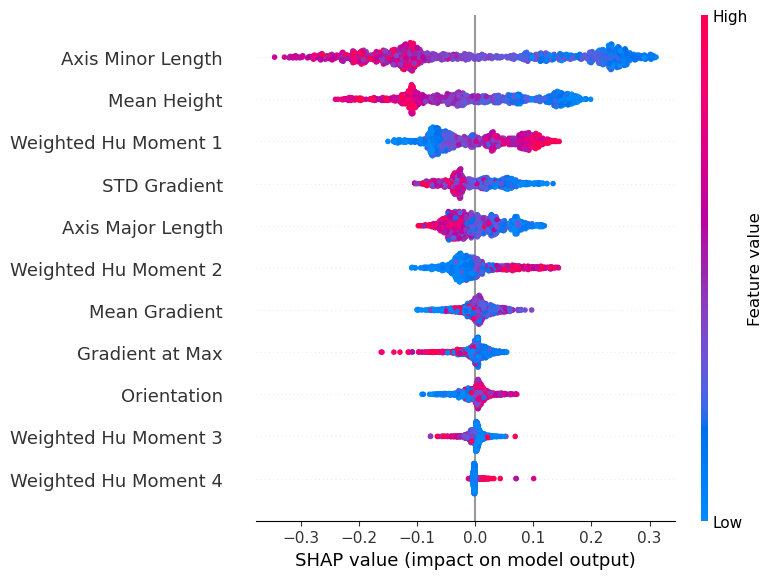

In [20]:
shap.summary_plot(shap_values[:,:,0], X, max_display=X.shape[1])

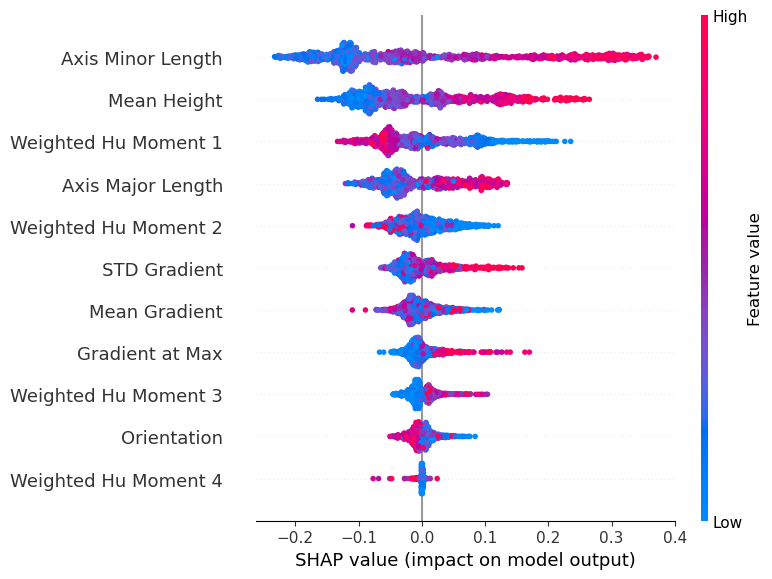

In [21]:
shap.summary_plot(shap_values[:,:,1], X, max_display=X.shape[1])

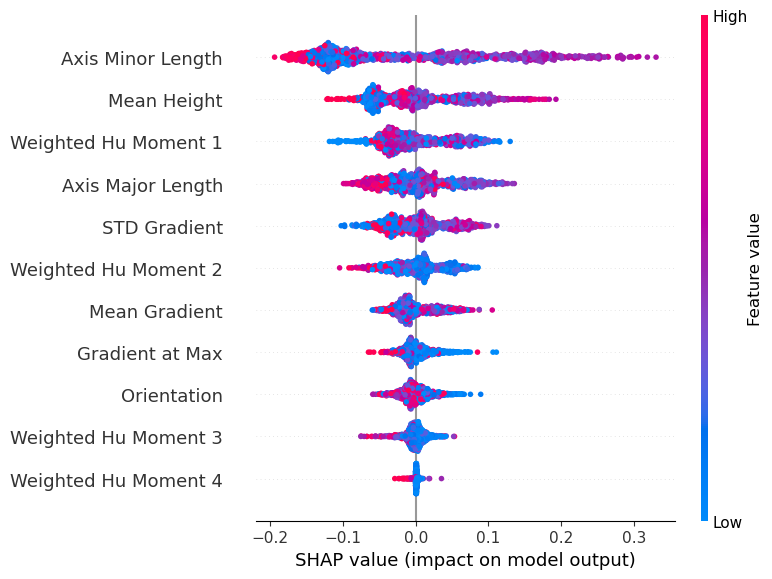

In [22]:
shap.summary_plot(shap_values[:,:,2], X, max_display=X.shape[1])

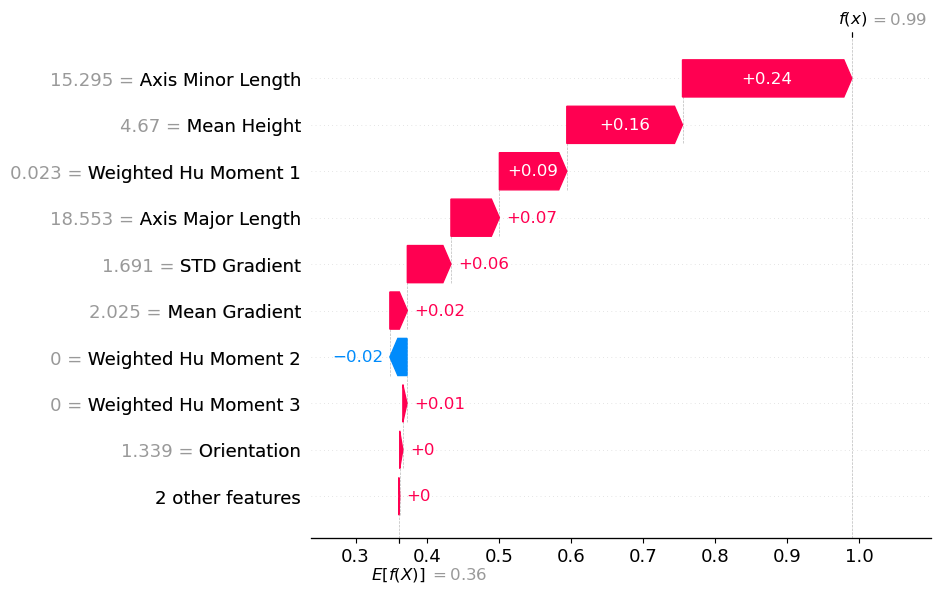

In [23]:
shap.plots.waterfall(shap_values[100,:,0])

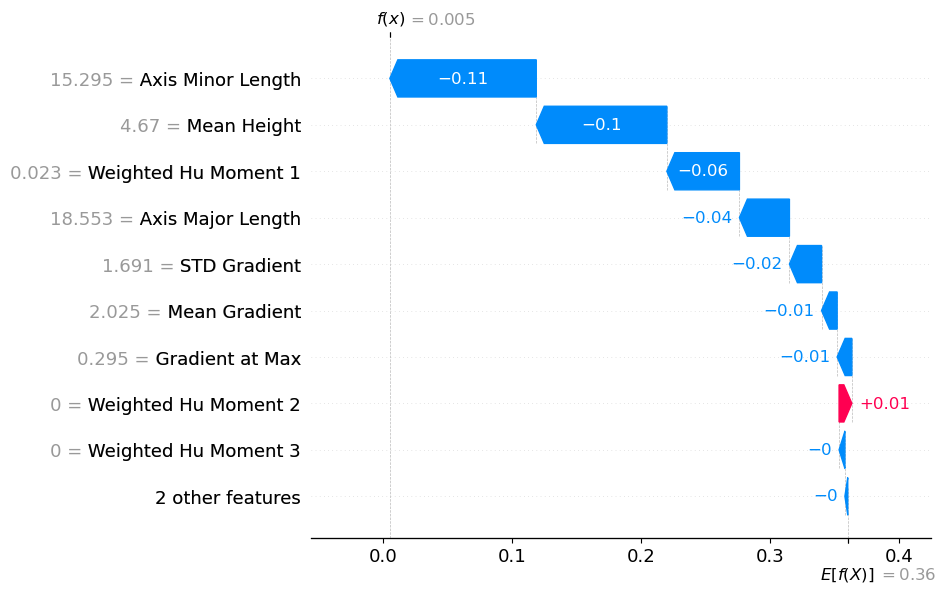

In [24]:
shap.plots.waterfall(shap_values[100,:,1])

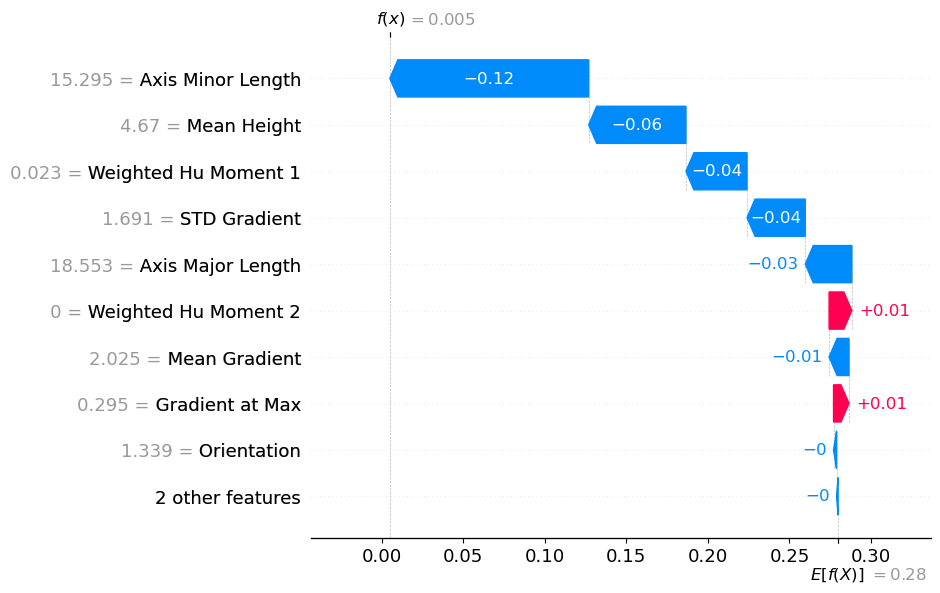

In [25]:
shap.plots.waterfall(shap_values[100,:,2])

In [26]:
X.columns

Index(['Orientation', 'Axis Major Length', 'Axis Minor Length', 'Mean Height',
       'Mean Gradient', 'STD Gradient', 'Gradient at Max',
       'Weighted Hu Moment 1', 'Weighted Hu Moment 2', 'Weighted Hu Moment 3',
       'Weighted Hu Moment 4'],
      dtype='object')

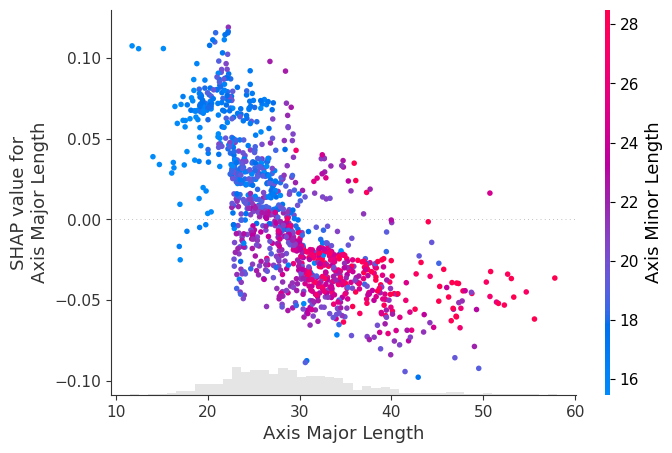

In [27]:
shap.plots.scatter(shap_values[:,1,0], color=shap_values[:,2,0])

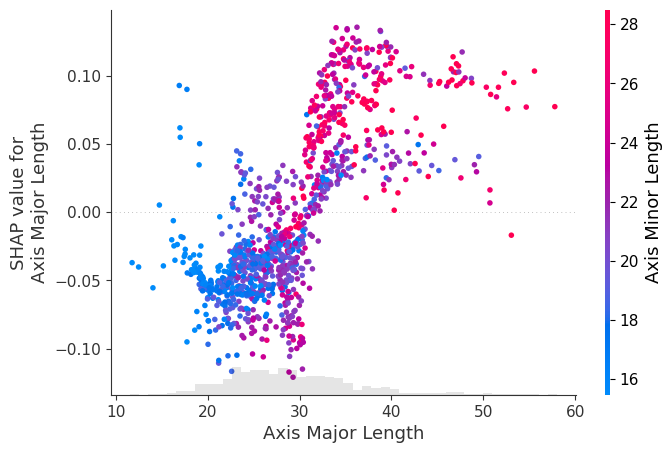

In [28]:
shap.plots.scatter(shap_values[:,1,1], color=shap_values[:,2,1])

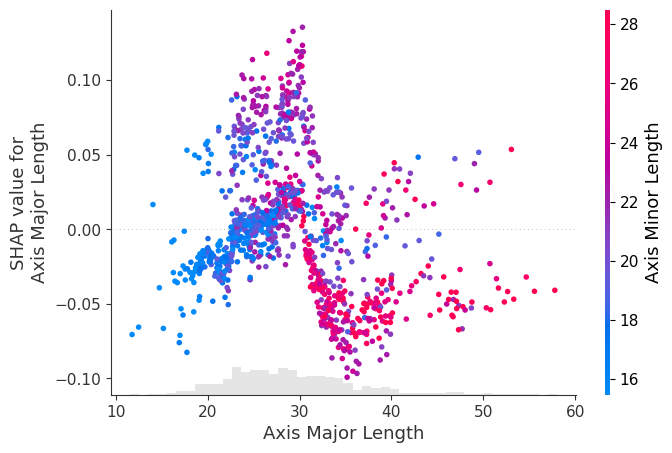

In [29]:
shap.plots.scatter(shap_values[:,1,2], color=shap_values[:,2,2])

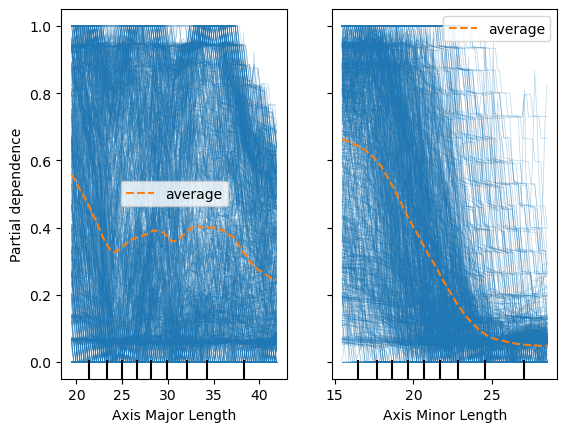

In [32]:
best_model = KNeighborsClassifier(n_neighbors=15, weights='distance')
best_model.fit(X, y)
features_PDP = ["Axis Major Length", "Axis Minor Length"]
PartialDependenceDisplay.from_estimator(best_model, X, features_PDP, kind='both', target=12)

PyALE._ALE_generic:INFO: Continuous feature detected.


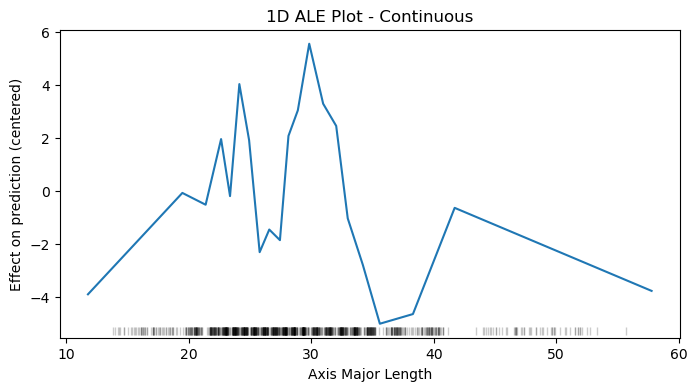

In [40]:
ale_eff = ale(X=X, model=best_model, feature=["Axis Major Length"], grid_size=20, include_CI=False)

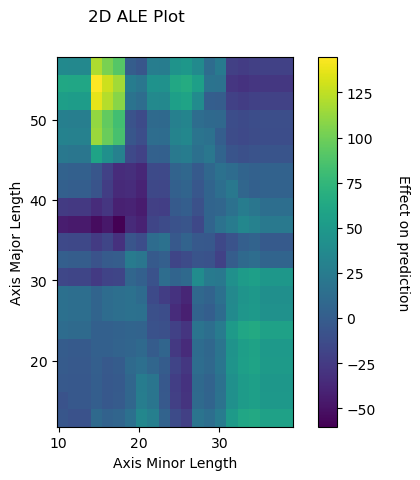

In [41]:
ale_eff = ale(X=X, model=best_model, feature=features_PDP, grid_size=20, include_CI=False)

In [42]:
explainer = lime.lime_tabular.LimeTabularExplainer(X.to_numpy(), class_names=['12', '58', '34'], feature_names = X.columns, kernel_width=2, mode='classification')

In [44]:
i = np.random.randint(0, X.shape[0])
exp = explainer.explain_instance(X.iloc[i,:], best_model.predict_proba, num_features=X.shape[1], top_labels=1)
exp.save_to_file(f'original_lime_row{i}.html')

# Model training - change Mean height to Max Height (based on SHAP results)

In [6]:
df = pd.read_csv('../data/rock_data.csv')

# handle missing values
if df.isnull().values.any():
    df.fillna(df.mean(), inplace=True)
    print('Missing values filled with mean.')

# detect and remove outliers

# drop highly correlated features
df.drop(['Area', 'Perimeter','Median Height', 'Mean Height', 'STD Height'], axis=1, inplace=True)
df.columns

Index(['Sample ID', 'Rock ID', 'Class', 'Orientation', 'Axis Major Length',
       'Axis Minor Length', 'Max Height', 'Mean Gradient', 'STD Gradient',
       'Gradient at Max', 'Weighted Hu Moment 1', 'Weighted Hu Moment 2',
       'Weighted Hu Moment 3', 'Weighted Hu Moment 4'],
      dtype='object')

In [7]:
X = df.iloc[:,3:].to_numpy(dtype=float)

def map_class_values(x):
    mapping = {12: 0, 58: 1, 34: 2}
    return mapping.get(x,None)

y = np.vectorize(map_class_values)(df['Class'].values)

In [8]:
# training:validation:testing = 60:20:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)

In [9]:
model_names = ['KNN', 'SVC', 'RF', 'XGB', 'MLP']
models = [KNeighborsClassifier(), SVC(), RandomForestClassifier(), XGBClassifier(), MLPClassifier(max_iter=500)]
grid_params = [{'n_neighbors': [5, 10, 15, 20], 'weights': ['uniform', 'distance']}, {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'sigmoid']}, {'n_estimators': [10, 100, 200], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_features': ['sqrt', 'log2', None]}, {'max_depth': [3,5,7], 'n_estimators': [10, 100, 200], 'reg_lambda': [1e-3, 1, 1e3]}, {'hidden_layer_sizes': [(100,), (100,50), (100,50,100)], 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'alpha': [1e-3, 1, 1e3]}]

KNN with {'n_neighbors': 20, 'weights': 'uniform'} 
               precision    recall  f1-score   support

           0       0.77      0.83      0.80        88
           1       0.44      0.43      0.43        54
           2       0.75      0.70      0.72        76

    accuracy                           0.68       218
   macro avg       0.65      0.65      0.65       218
weighted avg       0.68      0.68      0.68       218




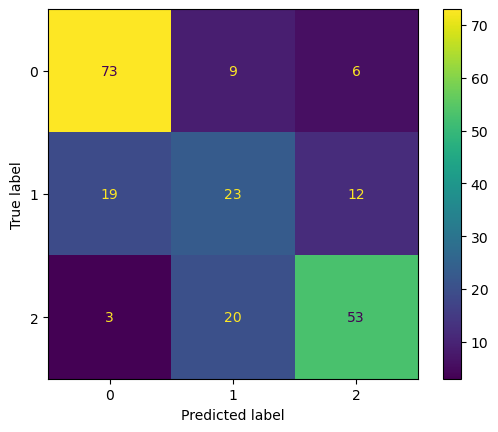

SVC with {'C': 0.1, 'kernel': 'linear'} 
               precision    recall  f1-score   support

           0       0.80      0.77      0.79        88
           1       0.49      0.57      0.53        54
           2       0.79      0.72      0.75        76

    accuracy                           0.71       218
   macro avg       0.69      0.69      0.69       218
weighted avg       0.72      0.71      0.71       218




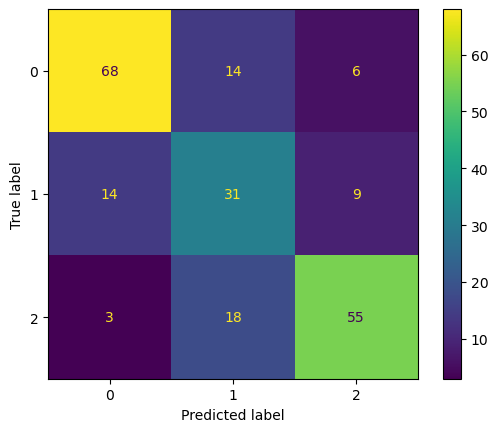

RF with {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 200} 
               precision    recall  f1-score   support

           0       0.77      0.81      0.79        88
           1       0.48      0.54      0.50        54
           2       0.78      0.67      0.72        76

    accuracy                           0.69       218
   macro avg       0.68      0.67      0.67       218
weighted avg       0.70      0.69      0.70       218




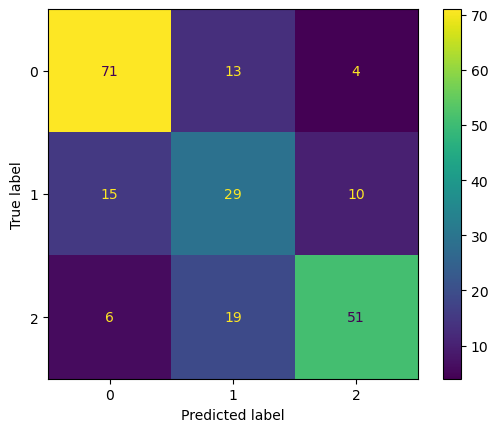

[16:48:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:32] WARNI

[16:48:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:36] WARNI

[16:48:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:45] WARNI

[16:48:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:52] WARNI

[16:49:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:49:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:49:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:49:01] WARNI

[16:49:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:49:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:49:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:49:11] WARNI

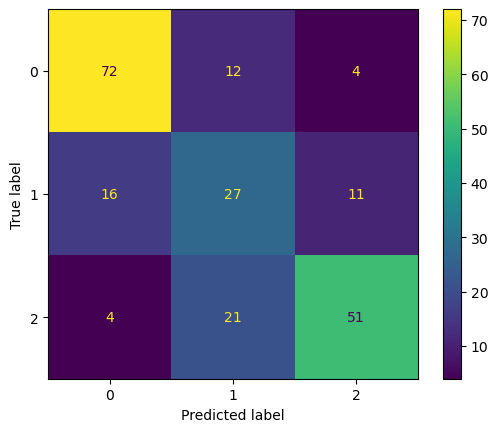

In [ ]:
dataset = 'max_height'
for m,model in enumerate(models):
    grid_search = GridSearchCV(model, grid_params[m], cv=5)
    grid_search.fit(X_train, y_train)
    model_best = grid_search.best_estimator_
    model_best_pred = model_best.predict(X_val)
    # Parse report to dataframe to compare results among models
    if m==0:
        results_df = parse_report(y_val, model_best_pred, m, model_names, grid_search, dataset)
    else:
        df_i = parse_report(y_val, model_best_pred, m, model_names, grid_search, dataset)
        results_df = pd.concat([results_df, df_i])
    # Print results
    print(f'{model_names[m]} with {grid_search.best_params_} \n {classification_report(y_val, model_best_pred)}\n')
    ConfusionMatrixDisplay(confusion_matrix(y_val, model_best_pred)).plot()
    show()

In [72]:
results_df

,model,params,class_0_precision,class_0_recall,class_0_f1-score,class_0_support,class_1_precision,class_1_recall,class_1_f1-score,class_1_support,...,class_2_support,accuracy,macro_avg_precision,macro_avg_recall,macro_avg_f1-score,macro_avg_support,weighted_avg_precision,weighted_avg_recall,weighted_avg_f1-score,weighted_avg_support
0,KNN,"{'n_neighbors': 20, 'weights': 'uniform'}",0.768421,0.829545,0.797814,88,0.442308,0.425926,0.433962,54,...,76,76,0.652403,0.650947,0.650955,218,0.679991,0.683486,0.680937,218
1,SVC,"{'C': 0.1, 'kernel': 'linear'}",0.800000,0.772727,0.786127,88,0.492063,0.574074,0.529915,54,...,76,76,0.692593,0.690162,0.689822,218,0.718742,0.706422,0.711261,218
2,RF,"{'criterion': 'entropy', 'max_features': 'log2...",0.780220,0.806818,0.793296,88,0.467742,0.537037,0.500000,54,...,76,76,0.677526,0.671636,0.672233,218,0.704349,0.692661,0.696279,218
3,XGB,"{'max_depth': 5, 'n_estimators': 200, 'reg_lam...",0.782609,0.818182,0.800000,88,0.450000,0.500000,0.473684,54,...,76,76,0.668445,0.663078,0.663998,218,0.696774,0.688073,0.690690,218
4,MLP,"{'activation': 'logistic', 'alpha': 0.001, 'hi...",0.747368,0.806818,0.775956,88,0.489362,0.425926,0.455446,54,...,76,76,0.666629,0.665301,0.664853,218,0.688963,0.697248,0.692102,218
